<a href="https://colab.research.google.com/github/zinoubm/Upwork_Portfolio/blob/main/Blood_Cell_Det.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
A complete blood count is one of the significant clinical tests that evaluates overall human health and provides relevant information for disease diagnosis. The conventional strategies of blood cell counting include manual counting as well as counting using the hemocytometer and are tedious and time-consuming tasks. 
In this project we will develop a software based solution, This will allow researchers and healtcare providers to achieve accurate and cost-effective results.
We will not perform the counting, but we will provide a platform that will allow for multiple usecases by the users. 

# Yolov5 Set Up

In [ ]:
from google.colab import output

! git clone https://github.com/ultralytics/yolov5
! pip install -r yolov5/requirements.txt

output.clear()

# Importing Libraries

In [ ]:
import torch
from IPython.display import Image
import os 
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

random.seed(108)

# Getting the Data

In [ ]:
%mkdir blood_cell_dataset
%cd blood_cell_dataset
! cp ../drive/MyDrive/BCCD.v4-416x416_aug.voc.zip .
! unzip BCCD.v4-416x416_aug.voc.zip

output.clear()

In [ ]:
%rm -r BCCD.v4-416x416_aug.voc.zip

In [ ]:
%mkdir /content/blood_cell_dataset/all_data /content/blood_cell_dataset/all_annot

In [ ]:
from pathlib import Path

root = Path('/content/blood_cell_dataset')
folders = ['test', 'train', 'valid']
dest_path_data = root / 'all_data'
dest_path_annot = root / 'all_annot'
def move_folder(folder_path, dest_path, type):
  for file in folder_path.glob(f'*.{type}'):
    file.rename(dest_path / file.name)

folder_paths = [root / x for x in folders]

for folder_path in folder_paths:
  move_folder(folder_path, dest_path_data, "jpg")
for folder_path in folder_paths:
  move_folder(folder_path, dest_path_annot, "xml")

In [ ]:
%rm -r test train valid README.dataset.txt README.roboflow.txt

# Converting Xml annotations to Yolov5 representation

Let's take a loot at the current representation.

In [ ]:
! cat ./all_annot/BloodImage_00383_jpg.rf.d1cd6ef5d4ae9b881c84a9b07fa53118.xml

<annotation>
	<folder></folder>
	<filename>BloodImage_00383_jpg.rf.d1cd6ef5d4ae9b881c84a9b07fa53118.jpg</filename>
	<path>BloodImage_00383_jpg.rf.d1cd6ef5d4ae9b881c84a9b07fa53118.jpg</path>
	<source>
		<database>roboflow.ai</database>
	</source>
	<size>
		<width>416</width>
		<height>416</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>RBC</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<occluded>0</occluded>
		<bndbox>
			<xmin>301</xmin>
			<xmax>375</xmax>
			<ymin>226</ymin>
			<ymax>304</ymax>
		</bndbox>
	</object>
	<object>
		<name>RBC</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<occluded>0</occluded>
		<bndbox>
			<xmin>86</xmin>
			<xmax>159</xmax>
			<ymin>73</ymin>
			<ymax>180</ymax>
		</bndbox>
	</object>
	<object>
		<name>RBC</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<occluded>0</occluded>
		<bndbox>
			<xm

In [ ]:
def get_xml_data(xml_file, log = False):
  tree = ET.parse(xml_file)
  root = tree.getroot()

  info_dict = {}
  info_dict["boxes"] = []

  info_dict["filename"] = root.find('filename').text

  info_dict["image_size"] = tuple(int(subSize.text) for subSize in root.find("size"))

  for obj in root.iter('object'):
    data = {}
    data['class'] = obj.find('name').text
    data['pose'] = obj.find('pose').text
    data['truncated'] = obj.find('truncated').text
    data['difficult'] = obj.find('difficult').text
    data['occluded'] = obj.find('occluded').text
    data['xmin'] = int(obj.find('bndbox').find('xmin').text)
    data['xmax'] = int(obj.find('bndbox').find('xmax').text)
    data['ymin'] = int(obj.find('bndbox').find('ymin').text)
    data['ymax'] = int(obj.find('bndbox').find('ymax').text)

    info_dict["boxes"].append(data)

  if log:
    print(info_dict["filename"])
    print(info_dict["image_size"])
    print(info_dict["boxes"])

  return info_dict

In [ ]:
class_name_to_id_mapping = {
    "WBC" : 0,
    "RBC" : 1,
    "Platelets" : 2
}

def convert_to_yoloV5(info_dict):
  print_buffer = []

  for box in info_dict["boxes"]:
    try:
      class_id = class_name_to_id_mapping[box["class"]]
    except:
      print('invalid class')
    
    center_x = (box["xmin"] + box["xmax"])/2
    center_y = (box["ymin"] + box["ymax"])/2
    width = box["xmax"] - box["xmin"]
    height = box["ymax"] - box["ymin"]

    image_width, image_height, image_depth = info_dict["image_size"]
    center_x /= image_width
    center_y /= image_height
    width /= image_width
    height /= image_height
 
    print_buffer.append(f"{class_id} {center_x:.3f} {center_y:.3f} {width:.3f} {height:.3f}")

  annotations = Path("all_annot")
  if not annotations.exists():
    annotations.mkdir()
  save_file_path = annotations / info_dict["filename"].replace(".jpg", ".txt")
  if not save_file_path.exists():
    save_file_path.touch()

  print("\n".join(print_buffer), file = save_file_path.open("w"))

In [ ]:
for xml_file in Path("all_annot").glob("*.xml"):
  xml_info_dict = get_xml_data(xml_file, log = False)
  convert_to_yoloV5(xml_info_dict)

In [ ]:
final_annot = [txt_file for txt_file in Path("all_annot").glob("*.txt")]
all_xml_annot = [xml_file for xml_file in Path("all_annot").glob("*.xml")]

Let's plot an image to check our transformation.

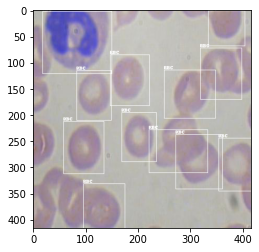

In [ ]:
class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))

def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size
    
    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)))
        
        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])
    
    plt.imshow(np.array(image))
    plt.show()

# Get any random annotation file 
annotation_file = random.choice(final_annot)
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

#Get the corresponding image file
image_file = str(annotation_file).replace("all_annot", "all_data").replace("txt", "jpg")
assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)

# Splitting to Train and Test sets

In [ ]:
images = [image for image in Path("all_data").glob("*.jpg")]
annotations = [annot for annot in Path("all_annot").glob("*.txt")]
images.sort()
annotations.sort()

train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 1)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 1)

In [ ]:
%mkdir images/train images/val images/test annotations/train annotations/val annotations/test -p

In [ ]:
def move_files_to_folder(files_list, destination_path):
  destination_path = Path(destination_path)
  for file in files_list:
    if destination_path.exists():
      file.rename(destination_path / file.name)

move_files_to_folder(train_images, 'images/train')
move_files_to_folder(val_images, 'images/val/')
move_files_to_folder(test_images, 'images/test/')
move_files_to_folder(train_annotations, 'annotations/train/')
move_files_to_folder(val_annotations, 'annotations/val/')
move_files_to_folder(test_annotations, 'annotations/test/')

In [ ]:
%rm -r all_annot all_data

In [ ]:
%mv annotations labels
%cd ../yolov5 

/content/yolov5


# Configuration

In [ ]:
!touch data/blood_cell.yaml

data = '''train: ../blood_cell_dataset/images/train/ 
val:  ../blood_cell_dataset/images/val/
test: ../blood_cell_dataset/images/test/

# number of classes
nc: 3

# class names
names: ["WBC","RBC", "Platelets"]'''

with open('/content/yolov5/data/blood_cell.yaml', 'a') as data_file:
    data_file.write(data)

In [ ]:
!touch data/hyp.scratch.yaml

hyper_param = '''# Hyperparameters for COCO training from scratch
# python train.py --batch 40 --cfg yolov5m.yaml --weights '' --data coco.yaml --img 640 --epochs 300
# See tutorials for hyperparameter evolution https://github.com/ultralytics/yolov5#tutorials


lr0: 0.01  # initial learning rate (SGD=1E-2, Adam=1E-3)
lrf: 0.2  # final OneCycleLR learning rate (lr0 * lrf)
momentum: 0.937  # SGD momentum/Adam beta1
weight_decay: 0.0005  # optimizer weight decay 5e-4
warmup_epochs: 3.0  # warmup epochs (fractions ok)
warmup_momentum: 0.8  # warmup initial momentum
warmup_bias_lr: 0.1  # warmup initial bias lr
box: 0.05  # box loss gain
cls: 0.5  # cls loss gain
cls_pw: 1.0  # cls BCELoss positive_weight
obj: 1.0  # obj loss gain (scale with pixels)
obj_pw: 1.0  # obj BCELoss positive_weight
iou_t: 0.20  # IoU training threshold
anchor_t: 4.0  # anchor-multiple threshold
# anchors: 3  # anchors per output layer (0 to ignore)
fl_gamma: 0.0  # focal loss gamma (efficientDet default gamma=1.5)
hsv_h: 0.015  # image HSV-Hue augmentation (fraction)
hsv_s: 0.7  # image HSV-Saturation augmentation (fraction)
hsv_v: 0.4  # image HSV-Value augmentation (fraction)
degrees: 0.0  # image rotation (+/- deg)
translate: 0.1  # image translation (+/- fraction)
scale: 0.5  # image scale (+/- gain)
shear: 0.0  # image shear (+/- deg)
perspective: 0.0  # image perspective (+/- fraction), range 0-0.001
flipud: 0.0  # image flip up-down (probability)
fliplr: 0.5  # image flip left-right (probability)
mosaic: 1.0  # image mosaic (probability)
mixup: 0.0  # image mixup (probability)
copy_paste: 0.0 # segment copy-paste (probability)'''

with open('/content/yolov5/data/hyp.scratch.yaml', 'a') as hyper_param_file:
    hyper_param_file.write(hyper_param)

# Training
This saved note book is just for demonstration as an UpWork sample project so I just used 1 epoch, in the original notebook I used 100 epochs

In [ ]:
!python train.py --img 640 --cfg yolov5s.yaml --hyp hyp.scratch.yaml --batch 32 --epochs 1 --data blood_cell.yaml --weights yolov5s.pt --workers 24 --name yolo_blood_cell

train: weights=yolov5s.pt, cfg=yolov5s.yaml, data=blood_cell.yaml, hyp=hyp.scratch.yaml, epochs=1, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=24, project=runs/train, name=yolo_blood_cell, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-53-g65071da Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.2, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7,

# Saving our results
Since this notebook is just for demonstration we dont need to save results, So the saving code is commented.

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

# !cp '/content/gdrive/My Drive/best.pt' best.pt